In [1]:
import pandas as pd

# shot_list_sheet_1 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet1')
# shot_list_sheet_2 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet2')
short_list_sheet = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv")

In [2]:
short_list_sheet

,shot,year,tftsrt,tipminf,tTQend,Isdata
0,12350,2015,1.500,5.246,5.2248,NaN
1,12372,2015,0.700,3.818,3.8026,NaN
2,12415,2015,1.900,4.769,4.7450,NaN
3,12438,2015,1.100,3.702,3.6826,NaN
4,12481,2015,1.900,5.217,5.1923,NaN
...,...,...,...,...,...,...
1091,21730,2018,1.500,4.968,4.9490,NaN
1092,21731,2018,1.500,4.913,4.8950,NaN
1093,21735,2018,1.500,89.746,89.7320,NaN
1094,21747,2018,3.724,11.451,11.4190,NaN


In [3]:

from src.dataloader import VideoDataset
from torch.utils.data import DataLoader

batch_size = 4
clip_len = 10
train_data_dist10 = VideoDataset(dataset = "fast_model_dataset", split = "train", clip_len = clip_len, preprocess = False)
train_loader_dist10 = DataLoader(train_data_dist10, batch_size = batch_size, shuffle = True, num_workers = 4)


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of train videos: 1240


In [4]:
sample_data, sample_label = next(iter(train_loader_dist10))
sample_img = sample_data[0, :, 0, :, :]

print("sample_img : ", sample_img.size())

from src.utility import show_frame

show_frame(sample_img)

sample_img :  torch.Size([3, 112, 112])


ModuleNotFoundError: No module named 'src.utility'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


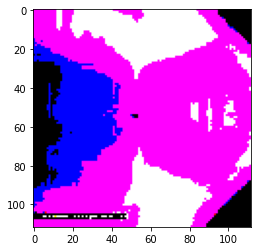

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


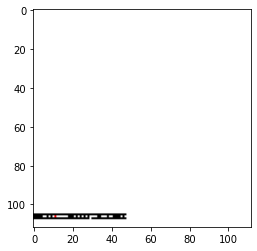

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


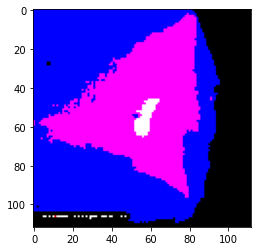

In [ ]:
for idx in range(sample_data.size(1)):
    sample_img = sample_data[0, :, idx, :, :]
    show_frame(sample_img)

In [ ]:
sample_data, sample_target = next(iter(train_loader_dist10))
print("sample data : ", sample_data.size())
print("sample target : ", sample_target.size())

sample data :  torch.Size([4, 3, 10, 112, 112])
sample target :  torch.Size([4])


In [ ]:
from src.model import VideoSpatioEncoder

encoder = VideoSpatioEncoder(
    input_shape  = (3, 8, 112, 112),
    alpha  = 0.01,
)

In [ ]:
sample_enc = encoder(sample_data)
print("sample_enc : ", sample_enc.size())

sample_enc :  torch.Size([4, 8, 23040])


In [ ]:
from src.transformer import SBERT
sbert = SBERT(
    num_features = sample_enc.size(-1),
    hidden = 128,
    n_layers = 4,
    attn_heads = 8, 
    max_len  = 8
)

In [ ]:
import torch

sample_doy = torch.tensor([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
sample_mask = None

sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)

In [ ]:
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [ ]:
sample_doy = torch.IntTensor(list(map(int, range(1, 8 + 1)))).repeat(sample_enc.size(0), 1)
sample_mask = None
sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [ ]:
from src.model import SBERTDisruptionClassifier

model = SBERTDisruptionClassifier(
    spatio_encoder = encoder, 
    sbert = sbert, 
    mlp_hidden = 128, 
    num_classes = 2
)

In [ ]:
model.sbert.num_features

23040

In [ ]:
step1 = model.spatio_encoder(sample_data)
print(step1.size())

torch.Size([4, 8, 23040])


In [ ]:
model.classifier

MulticlassClassifier(
  (pooling): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
from src.transformer import MulticlassClassifier

classifier = MulticlassClassifier(
    enc_dims = 128,
    hidden  = 128,
    num_classes=2
)

classifier(sample_sbert_output)

tensor([[-0.3567, -0.0086],
        [ 0.4533,  0.4578],
        [-0.1101, -0.7663],
        [-0.4707, -0.1685]], grad_fn=<AddmmBackward0>)

In [ ]:
model.forward(sample_data)

tensor([[ 0.0392, -0.2073],
        [-0.5427,  0.1150],
        [-0.5553, -0.2493],
        [ 0.4135,  0.1297]], grad_fn=<AddmmBackward0>)

In [ ]:
from src.model import *

r21p = R2Plus1DClassifier(
        input_size  = (3, 8, 112, 112),
        num_classes = 2, 
        layer_sizes = [2,2,2,2], 
        pretrained = False, 
        alpha = 0.01
)

video_encoder = VideoSpatioEncoder(
    input_shape  = (3, 8, 112, 112),
    alpha  = 0.01,
)

temporal_encoder = SBERT(
    num_features = 18432,
    hidden = 128,
    n_layers = 4,
    attn_heads = 8, 
    max_len  = 8
)

sbert_model = SBERTDisruptionClassifier(
    spatio_encoder = video_encoder, 
    sbert = temporal_encoder, 
    mlp_hidden = 128, 
    num_classes = 2
)

In [ ]:
r21p.summary()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Parent Layers             Layer (type)             Input Shape         Param #     Tr. Param #
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock                 Conv3d-1     [1, 3, 8, 112, 112]           6,615           6,615
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock            BatchNorm3d-2      [1, 45, 8, 56, 56]              90              90
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock              LeakyReLU-3      [1, 45, 8, 56, 56]               0               0
                                        

In [ ]:
sbert_model.summary()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                              Parent Layers             Layer (type)                                     Input Shape         Param #     Tr. Param #
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock                 Conv3d-1                             [8, 3, 8, 112, 112]           1,728           1,728
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock            BatchNorm3d-2                              [8, 64, 8, 56, 56]             128             128
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock              LeakyReLU-3                              [8, 64, 8, 56, 56]               0               0
                SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock                 Con

In [ ]:
from src.model import SlowFastEncoder
from src.resnet import Bottleneck3D

slowfast = SlowFastEncoder(
    input_shape = (3,8,112,112),
    block = Bottleneck3D,
    layers = [1,2,2,1],
    alpha = 4,
    p = 0.5
)

slowfast.summary()

------------------------------------------------------------------------------------------------------------------
                          Parent Layers       Layer (type)             Input Shape         Param #     Tr. Param #
                SlowFastEncoder/FastNet           Conv3d-1     [8, 3, 8, 112, 112]           2,368           2,368
                SlowFastEncoder/FastNet      BatchNorm3d-2      [8, 16, 8, 56, 56]              32              32
                SlowFastEncoder/FastNet             ReLU-3      [8, 16, 8, 56, 56]               0               0
                SlowFastEncoder/FastNet        MaxPool3d-4      [8, 16, 8, 56, 56]               0               0
                SlowFastEncoder/FastNet           Conv3d-5      [8, 16, 8, 28, 28]           1,536           1,536
   SlowFastEncoder/FastNet/Bottleneck3D           Conv3d-6      [8, 16, 8, 28, 28]             768             768
   SlowFastEncoder/FastNet/Bottleneck3D      BatchNorm3d-7      [8, 16, 8, 28, 2

In [ ]:
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

num_replicas = 2
rank = 1
num_workers = 4
train_sampler = DistributedSampler(train_data_dist10, num_replicas=num_replicas, rank = rank, shuffle = True)
train_loader_distributed = DataLoader(train_data_dist10, batch_size, sampler = train_sampler, num_workers = num_workers, pin_memory=True)

In [ ]:
sample_x, sample_y = next(iter(train_loader_distributed))

In [ ]:
train_sampler.rank

1

In [ ]:
os.getcwd()

'/home/zinzinbin/codes_for_study/fusion-plasma/research-predict-disruption'

In [ ]:
import os
import numpy as np

label = []

path = "./dataset/dur0.2_dis100/"

dir_list = os.listdir(path)
num = 2
for i in dir_list[-2:] :
    file_list = os.listdir(path+i)
    for file_name in file_list :
        full_filename = path + "{}/{}".format(i, file_name)
        label.append("{} {}\n".format(full_filename, num))
    num -= 1

In [ ]:
import random

label = []
num = 0

nomal_path = path + "nomal"
dis_path = path + "disruption"

dis_list = os.listdir(dis_path)

for file_name in dis_list :
    full_filename = "{}/{}".format(dis_path, file_name)
    label.append("{} {}\n".format(full_filename, num))
num+= 1


nom_list = os.listdir(nomal_path)
ran_nom = random.sample(nom_list, len(dis_list))

for file_name in ran_nom :
    full_filename = "{}/{}".format(nomal_path, file_name)
    label.append("{} {}\n".format(full_filename, num))

In [ ]:
len(nom_list), len(dis_list), len(ran_nom), len(label)

(4388, 79, 79, 158)

In [ ]:
f = open("label.txt", 'w')
for i in label:
    data = i
    f.write(data)
f.close()

In [ ]:
val_size = 0.1

val_num = int(len(dis_list)*val_size)
train_num = len(dis_list) - val_num

dis_train_list = np.random.choice(dis_list, train_num, replace=False)
diff_dis_train = np.setdiff1d(dis_list, dis_train_list)
dis_val_list = np.random.choice(diff_dis_train, val_num, replace=False)

In [ ]:
len(dis_train_list), len(dis_val_list)

(72, 7)

In [ ]:
dir_list

['disruption', 'borderline', 'nomal']

In [ ]:
import random

train_label = []
val_label = []
label = 1

train_num = 0
val_num = 0

nomal_dirname = 'nomal'
dis_dirname = 'disruption'

nomal_path = path+nomal_dirname
dis_path = path+dis_dirname

dis_list = os.listdir(dis_path)

val_size = 0.1

val_num = int(len(dis_list)*val_size)
train_num = len(dis_list) - val_num

dis_train_list = np.random.choice(dis_list, train_num, replace=False)
diff_dis_train = np.setdiff1d(dis_list, dis_train_list)
dis_val_list = np.random.choice(diff_dis_train, val_num, replace=False)

# train label
for file_name in dis_train_list:
    full_filename = "{}/{}".format(dis_dirname, file_name)
    train_label.append("{} {}\n".format(full_filename, label))

# val label 
for file_name in dis_val_list:
    full_filename = "{}/{}".format(dis_dirname, file_name)
    val_label.append("{} {}\n".format(full_filename, label))

label -= 1
    
nom_list = os.listdir(nomal_path)
nom_train_list = np.random.choice(nom_list, train_num, replace=False)
diff_nom_train = np.setdiff1d(nom_list, nom_train_list)
nom_val_list = np.random.choice(diff_nom_train, val_num, replace=False)

for file_name in nom_train_list :
    full_filename = "{}/{}".format(nomal_dirname, file_name)
    train_label.append("{} {}\n".format(full_filename, label))
    
for file_name in nom_val_list :
    full_filename = "{}/{}".format(nomal_dirname, file_name)
    val_label.append("{} {}\n".format(full_filename, label))
    
random.shuffle(train_label)
random.shuffle(val_label)

In [ ]:
f = open("./dataset/train.txt", 'w')
for i in train_label:
    data = i
    f.write(data)
f.close()

f = open("./dataset/val_list.txt", 'w')
for i in val_label:
    data = i
    f.write(data)
f.close()

In [ ]:
f = open("./dataset/test_list.txt", 'w')
for i in train_label[:round(len(val_label)/2)]:
    data = i
    f.write(data)
f.close()

In [5]:
from src.dataloader import VideoDataset
from torch.utils.data import DataLoader

batch_size = 4
clip_len = 42
train_data_dist21 = VideoDataset(dataset = "dur0.2_dis21", split = "train", clip_len = clip_len, preprocess = False)
train_loader_dist21 = DataLoader(train_data_dist21, batch_size = batch_size, shuffle = True, num_workers = 4)


Number of train videos: 2951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample_img :  torch.Size([3, 112, 112])
sample label :  tensor([1, 1, 1, 1])


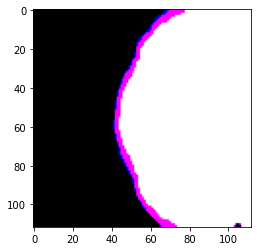

In [7]:
sample_data, sample_label = next(iter(train_loader_dist21))
sample_img = sample_data[0, :, 0, :, :]

print("sample_img : ", sample_img.size())
print("sample label : ", sample_label)

from src.utils.utility import show_frame

show_frame(sample_img)

In [8]:
import logging
logger = logging.getLogger(__name__)